In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
%matplotlib inline

In [6]:
from sklearn.datasets import load_sample_image

In [7]:
china=load_sample_image('china.jpg')/255
flower=load_sample_image('flower.jpg')/255
images=np.array([china,flower])
batch_size,height,widht,channels=images.shape

In [8]:
batch_size,height,widht,channels

(2, 427, 640, 3)

Text(0.5, 1.0, 'Flower')

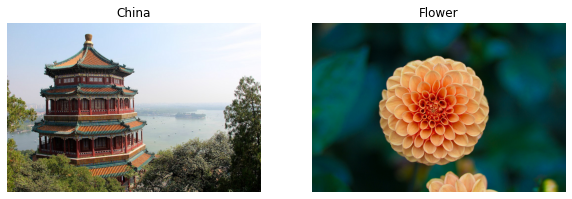

In [9]:
plt.figure(figsize=(10,8))

plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.title('China',fontsize=12)
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')
plt.title('Flower',fontsize=12)

In [12]:
filters=np.zeros(shape=(7,7,channels,2))
filters[:,3,:,0]=1
filters[3,:,:,1]=1

In [24]:
outputs=tf.nn.conv2d(images,filters,strides=1,padding='VALID')

Text(0.5, 1.0, 'Flower')

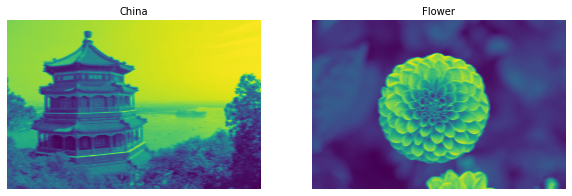

In [25]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(outputs[0,:,:,1])
plt.axis('off')
plt.title('China',fontsize=10)
plt.subplot(122)
plt.imshow(outputs[1,:,:,1])
plt.axis('off')
plt.title('Flower',fontsize=10)

In [22]:
conv=keras.layers.Conv2D(filters=32,kernel_size=3,strides=1,
                        padding='same',activation='relu')

In [23]:
conv

In [26]:
max_pool=keras.layers.MaxPool2D(pool_size=2)

In [28]:
output=tf.nn.max_pool(images,ksize=(1,1,1,3),
                     strides=(1,1,1,3),
                     padding='VALID')

Text(0.5, 1.0, 'Flower')

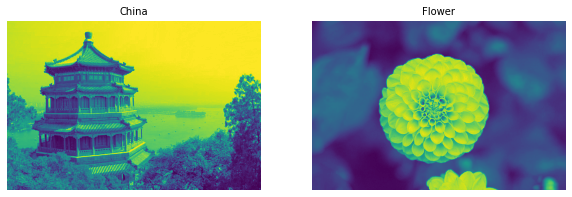

In [33]:
plt.figure(figsize=(10,8))

plt.subplot(121)
plt.imshow(output[0])
plt.axis('off')
plt.title('China',fontsize=10)

plt.subplot(122)
plt.imshow(output[1])
plt.axis('off')
plt.title('Flower',fontsize=10)

In [20]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self,filters,strides=1,activation='relu',**kwargs):
        super().__init__(**kwargs)
        self.activation=keras.activations.get(activation)
        self.main_layers=[
            keras.layers.Conv2D(filters,3,strides=strides,
                               padding='same',use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters,3,strides=1,
                               padding='same',use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers=[]
        if strides>1:
            self.skip_layers=[
                keras.layers.Conv2D(filters,1,strides=strides,
                                   padding='same',use_bias=False),
                keras.layers.BatchNormalization()
            ]
    def call(self,inputs):
        Z=inputs
        for layer in self.main_layers:
            Z=layer(Z)
        skip_Z=inputs
        for layer in self.skip_layers:
            skip_Z=layer(skip_Z)
        return self.activation(Z+skip_Z)

In [18]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [21]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7,strides=2,input_shape=[224,224,3],
                             padding='SAME',use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3,strides=2,padding='SAME'))
prev_filters=64
for filters in [64]*3+[128]*4+[256]*6+[512]*3:
    strides=1 if filters==prev_filters else 2
    model.add(ResidualUnit(filters,strides=strides))
    prev_filters=filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10,activation='softmax'))

In [22]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_5 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_3 (ResidualUni (None, 56, 56, 64)       

## Using Pretrained Models

In [24]:
model=keras.applications.resnet50.ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 89s 1us/step


In [28]:
def plot_color_image(image):
    plt.imshow(image,interpolation='nearest')
    plt.axis('off')
    
def plot_image(image):
    plt.imshow(image,cmap='gray',interpolation='nearest')
    plt.axis('off')

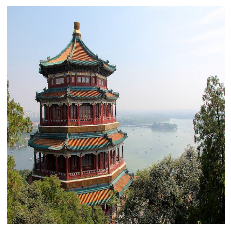

In [29]:
image_resized=tf.image.resize(images,[224,224])
plot_color_image(image_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


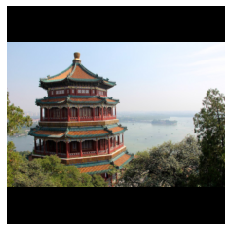

In [33]:
image_resized=tf.image.resize_with_pad(images,224,224,antialias=True)
plot_color_image(image_resized[0])
plt.show()

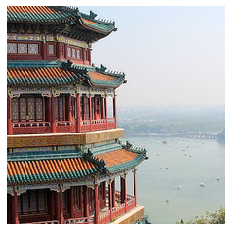

In [35]:
image_resized=tf.image.resize_with_crop_or_pad(images,224,224)
plot_color_image(image_resized[0])
plt.show()

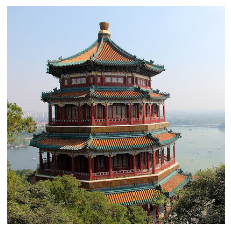

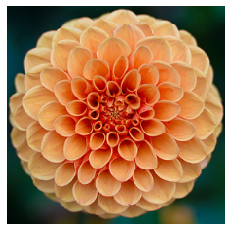

In [36]:
china_box=[0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
image_resized=tf.image.crop_and_resize(images,[china_box,flower_box],[0,1],[224,224])
plot_color_image(image_resized[0])
plt.show()
plot_color_image(image_resized[1])
plt.show()

In [39]:
inputs=keras.applications.resnet50.preprocess_input(image_resized*255)

In [40]:
y_proba=model.predict(inputs)

In [41]:
y_proba.shape

(2, 1000)

In [42]:
y_proba

array([[7.35480699e-09, 2.15529603e-08, 7.46987361e-09, ...,
        1.70623771e-09, 1.11732945e-07, 3.38286270e-08],
       [2.34772756e-07, 7.02716170e-06, 4.04805377e-07, ...,
        5.40231049e-05, 3.66757631e-05, 1.33724025e-04]], dtype=float32)

In [44]:
top_K=keras.applications.resnet50.decode_predictions(y_proba,top=3)
for image_index in range(len(images)):
    print('Image #{}'.format(image_index))
    for class_id,name,y_proba in top_K[image_index]:
        print(" {}-{:12s} {:.2f}%".format(class_id,name,y_proba*100))
    print()

Image #0
 n03877845-palace       43.39%
 n02825657-bell_cote    43.07%
 n03781244-monastery    11.70%

Image #1
 n04522168-vase         53.96%
 n07930864-cup          9.52%
 n11939491-daisy        4.97%



In [46]:
import tensorflow_datasets as tfds

dataset,info=tfds.load("tf_flowers",as_supervised=True,with_info=True)
dataset_size=info.splits['train'].num_examples

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tf_flowers-train.tfrecord...:   0%|          | 0/3670 [00:00<?, ? examples/s]

Dataset tf_flowers downloaded and prepared to C:\Users\Manan\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [47]:
dataset_size

3670

In [48]:
class_names=info.features['label'].names
n_classes=info.features['label'].num_classes

In [50]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [51]:
n_classes

5

In [53]:
test_split,valid_split,train_split=tfds.load('tf_flowers',
                                             split=['train[:10%]','train[10%:25%]','train[25%:]'],
                                            as_supervised=True)

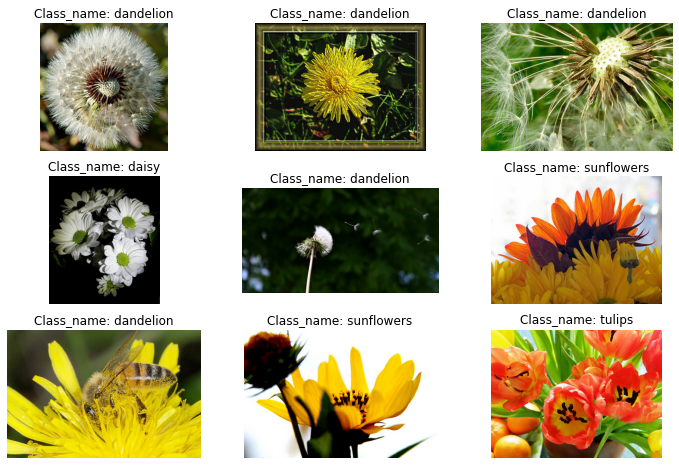

In [54]:
plt.figure(figsize=(12,8))
index=0
for image,label in train_split.take(9):
    index+=1
    plt.subplot(3,3,index)
    plt.imshow(image)
    plt.title("Class_name: {}".format(class_names[label]))
    plt.axis('off')
plt.show()

Basic Preprocessing

In [57]:
def preprocess(image,label):
    resized_image=tf.image.resize(image,[224,224])
    final_image=keras.applications.xception.preprocess_input(resized_image)
    return final_image,label

Advanced Preprocessing

In [58]:
def centeral_crop(image):
    shape=tf.shape(image)
    min_dim=tf.reduce_min([shape[0],shape[1]])
    top_crop=(shape[0]-min_dim)//4
    bottom_crop=shape[0]-top_crop
    left_crop=(shape[1]-min_dim)//4
    right_crop=shape[1]-left_crop
    return(image[top_crop:bottom_crop,left_crop:right_crop])

In [59]:
def random_crop(image):
    shape=tf.shape(image)
    min_dim=tf.reduce_min([shape[0],shape[1]])*90//100
    return tf.image.random_crop(image,[min_dim,min_dim,3])

In [73]:
def preprocess(image,label,randomize=False):
    if randomize:
        cropped_image=random_crop(image)
        cropprd_image=tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image=centeral_crop(image)
    resized_image=tf.image.resize(cropped_image,[224,224])
    final_image=keras.applications.xception.preprocess_input(resized_image)
    return final_image,label

In [64]:
from functools import partial

In [74]:
batch_size = 32
train_set = train_split.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_split.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_split.map(preprocess).batch(batch_size).prefetch(1)


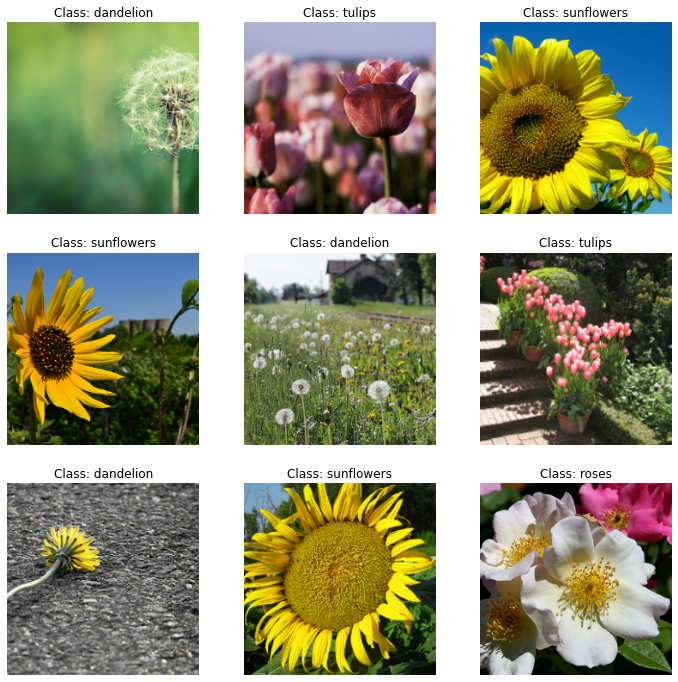

In [81]:
plt.figure(figsize=(12,12))

for X_batch,y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3,3,index+1)
        plt.imshow(X_batch[index]/2+0.5)
        plt.title('Class: {}'.format(class_names[y_batch[index]]))
        plt.axis('off') 
plt.show()

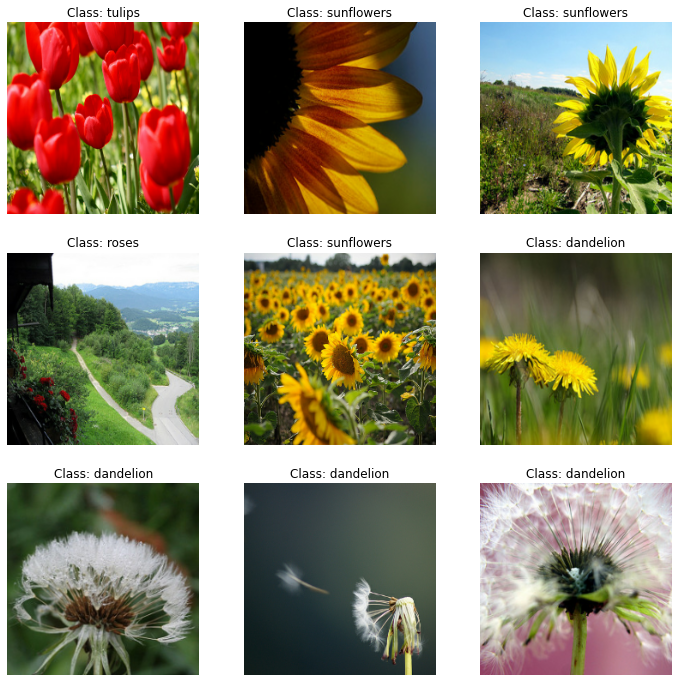

In [82]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [83]:
base_model=keras.applications.xception.Xception(weights='imagenet',
                                               include_top=False)
avg=keras.layers.GlobalAveragePooling2D()(base_model.output)
output=keras.layers.Dense(n_classes,activation='softmax')(avg)
model=keras.models.Model(inputs=base_model.input,outputs=output)

83689472/83683744 [==============================] - 126s 2us/step


In [84]:
for index,layer in enumerate(base_model.layers):
    print(index,layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_43
13 block2_pool
14 batch_normalization_42
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_44
23 block3_pool
24 batch_normalization_43
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_45
33 block4_pool
34 batch_normalization_44
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [90]:
for layer in base_model.layers:
    layer.trainable=False
optimizer=keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.1)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
             metrics=['accuracy'])
history=model.fit(train_set,
                 steps_per_epoch=int(0.75*dataset_size/batch_size),
                 validation_data=valid_set,
                 validation_steps=int(0.15*dataset_size/batch_size),
                 epochs=5)


Epoch 1/5
86/86 [==============================] - 445s 5s/step - loss: 0.7542 - accuracy: 0.8147 - val_loss: 0.6811 - val_accuracy: 0.8327
Epoch 2/5
86/86 [==============================] - 472s 6s/step - loss: 0.3480 - accuracy: 0.9019 - val_loss: 0.5477 - val_accuracy: 0.8713
Epoch 3/5
86/86 [==============================] - 469s 5s/step - loss: 0.2829 - accuracy: 0.9121 - val_loss: 0.5250 - val_accuracy: 0.8695
Epoch 4/5
86/86 [==============================] - 473s 5s/step - loss: 0.2318 - accuracy: 0.9291 - val_loss: 0.5177 - val_accuracy: 0.8732
Epoch 5/5
86/86 [==============================] - 472s 5s/step - loss: 0.2320 - accuracy: 0.9262 - val_loss: 0.4911 - val_accuracy: 0.8768


## Basic RNNs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
def generate_time_series(batch_size,n_steps):
    freq1,freq2,offsets1,offsets2=np.random.rand(4,batch_size,1)
    time=np.linspace(0,1,n_steps)
    series=0.5*np.sin((time-offsets1)*(freq1*10+10))
    series+=0.2*np.sin((time-offsets2)*(freq2*20+20))
    series+=0.1*(np.random.rand(batch_size,n_steps)-0.5)
    return series[...,np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps=50
series=generate_time_series(10000,n_steps+1)
X_train,y_train=series[:7000,:n_steps],series[:7000,-1]
X_valid,y_valid=series[7000:9000,:n_steps],series[7000:9000,-1]
X_test,y_test=series[9000:,:n_steps],series[9000:,-1]

In [13]:
X_train.shape,y_train.shape

((7000, 50, 1), (7000, 1))

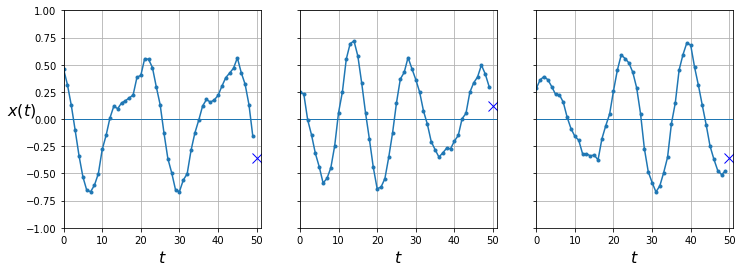

In [4]:
def plot_series(series,y=None,y_pred=None,x_label="$t$",y_label="$x(t)$"):
    plt.plot(series,'.-')
    if y is not None:
        plt.plot(n_steps,y,'bx',markersize=10)
    if y_pred is not None:
        plt.plot(n_steps,y_pred,'ro')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label,fontsize=16)
    if y_label:
        plt.ylabel(y_label,fontsize=16,rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    

fig,axes=plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(12,4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_train[col, :, 0], y_train[col, 0],
                y_label=("$x(t)$" if col==0 else None))

plt.show()

## Computing Baselines

In [33]:
y_pred=X_valid[:,-1]
y_pred.shape

(2000, 1)

In [35]:
np.mean(keras.losses.mean_squared_error(y_pred,y_valid))

<IPython.core.display.Javascript object>

0.020211367

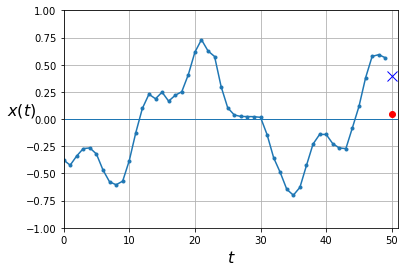

In [38]:
plot_series(X_valid[0,:,0],y_valid[0,0],y_test[0,0])

In [57]:
y_valid[0,0]

0.4000832

Linear Prediction

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])

model.compile(loss='mse',optimizer='adam')
history=model.fit(X_train,y_train,epochs=20,
                 validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [18]:
model.evaluate(X_valid,y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168087150901556

In [19]:
model.evaluate(X_test,y_test
              )

32/32 [==============================] - 0s 1ms/step - loss: 0.0042


0.00424182740971446

In [5]:
def plot_learning_curve(loss,val_loss):
    plt.plot(np.arange(len(loss))+0.5,loss,'b.-',label='Training Loss')
    plt.plot(np.arange(len(val_loss))+1,val_loss,'r.-',label='Validation Loss')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

<IPython.core.display.Javascript object>

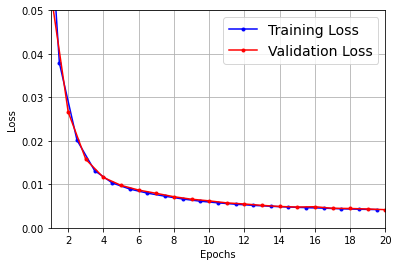

In [30]:
plot_learning_curve(history.history['loss'],history.history['val_loss'])

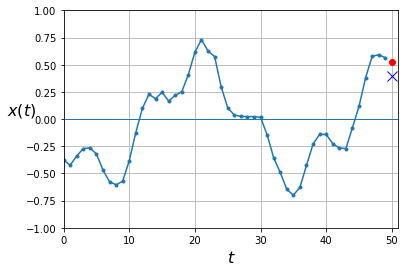

In [33]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])

## Simple RNN

In [7]:
import tensorflow as tf
from tensorflow import keras

In [14]:
X_train.shape

(7000, 50, 1)

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 14ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0116 - val_lo

<IPython.core.display.Javascript object>

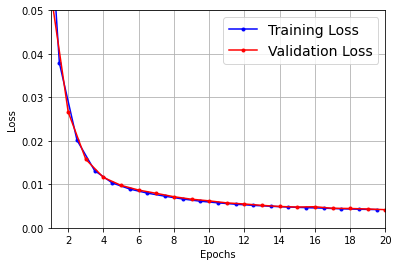

In [34]:
plot_learning_curve(history.history['loss'],history.history['val_loss'])

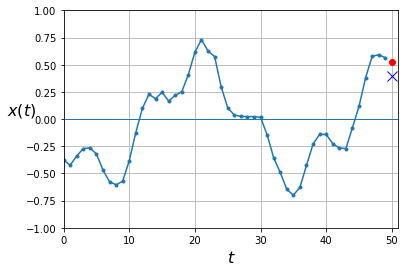

In [37]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])

## Deep RNNs

In [41]:
np.random.seed(42)
tf.random.set_seed(42)


model=keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
history=model.fit(X_train,y_train,epochs=20,
                 validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 11s 38ms/step - loss: 0.0492 - accuracy: 0.0000e+00 - val_loss: 0.0090 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0053 - accuracy: 0.0000e+00 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0045 - accuracy: 0.0000e+00 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0038 - accuracy:

In [42]:
model.evaluate(X_valid,y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0029 - accuracy: 0.0000e+00


[0.002910564187914133, 0.0]

<IPython.core.display.Javascript object>

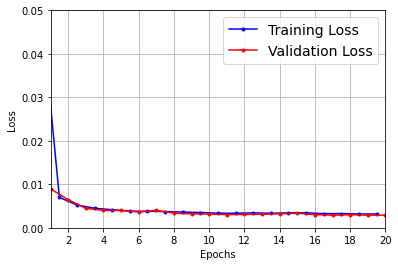

In [43]:
plot_learning_curve(history.history['loss'],history.history['val_loss'])

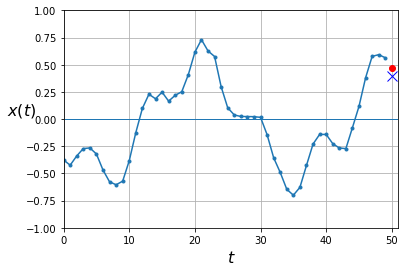

In [45]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss='mse',optimizer='adam')
history=model.fit(X_train,y_train,epochs=20,
                 validation_data=(X_valid,y_valid))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20
219/219 [==============================] - 52s 34ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0029 - val_l

In [49]:
model.evaluate(X_valid,y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0026


0.0026236227713525295

<IPython.core.display.Javascript object>

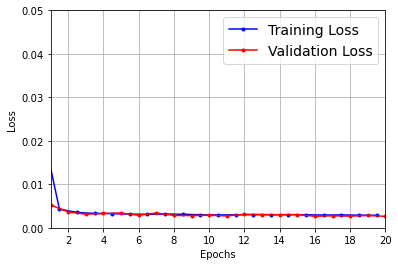

In [50]:
plot_learning_curve(history.history['loss'],history.history['val_loss'])

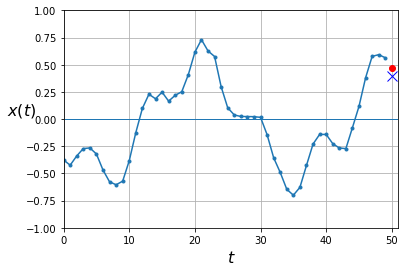

In [51]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])

## Forcasting several steps ahead

In [16]:

np.random.seed(43)
series=generate_time_series(1,n_steps+10)
X_new,Y_new=series[:,:n_steps],series[:,n_steps:]
X=X_new
for step_ahead in range(10):
    y_pred_one=model.predict(X[:,step_ahead:])[:,np.newaxis,:]
    X=np.concatenate([X,y_pred_one],axis=1)
    
Y_pred=X[:,n_steps:]

In [12]:
X.shape,X_new.shape

((1, 60, 1), (1, 50, 1))

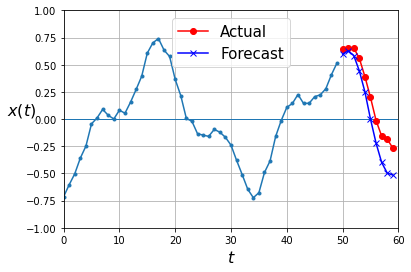

In [17]:
def plot_multiple_forecast(X,Y,Y_pred):
    n_steps=X.shape[1]
    ahead=Y.shape[1]
    plot_series(X[0,:,0])
    plt.plot(np.arange(n_steps,n_steps+ahead),Y[0,:,0],'ro-',label='Actual')
    plt.plot(np.arange(n_steps,n_steps+ahead),Y_pred[0,:,0],'bx-',label='Forecast')
    plt.axis([0,n_steps+ahead,-1,1])
    plt.legend(fontsize=15)
    
plot_multiple_forecast(X_new,Y_new,Y_pred)
plt.show()

In [12]:
np.random.seed(42)

n_steps=50
series=generate_time_series(10000,n_steps+10)
X_train,Y_train=series[:7000,:n_steps],series[:7000,-10:,0]
X_valid,Y_valid=series[7000:9000,:n_steps],series[7000:9000,-10:,0]
X_test,Y_test=series[9000:,:n_steps],series[9000:,-10:,0]

In [25]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [26]:
Y_pred.shape

(2000, 10)

In [27]:
np.mean(keras.metrics.mean_squared_error(Y_pred,Y_valid))

<IPython.core.display.Javascript object>

0.027510853

In [29]:
Y_naive_pred=np.tile(X_valid[:,-1],10)
np.mean(keras.metrics.mean_squared_error(Y_valid,Y_naive_pred))

<IPython.core.display.Javascript object>

0.25697407

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(10)
])

model.compile(loss='mse',optimizer='adam')
history=model.fit(X_train,y_train,epochs=20,
                 validation_data=(X_valid,y_valid))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20
219/219 [==============================] - 2s 3ms/step - loss: 0.2552 - val_loss: 0.0870
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0783 - val_loss: 0.0695
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0625
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0585
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0561 - val_loss: 0.0551
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0527
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0506
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0488
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0476
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0465

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss='mse',optimizer='adam')
history=model.fit(X_train,Y_train,epochs=20,
                 validation_data=(X_valid,Y_valid))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20
219/219 [==============================] - 12s 31ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0118 - val_l

In [43]:
np.random.seed(43)


series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [37]:
Y_pred.shape,Y_new.shape

((1, 10, 1), (1, 10, 1))

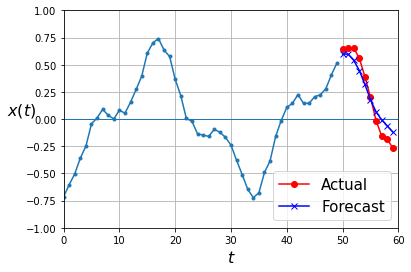

In [44]:
plot_multiple_forecast(X_new,Y_new,Y_pred)
plt.show()

In [52]:
np.random.seed(42)

n_steps=50
series=generate_time_series(10000,n_steps+10)
X_train= series[:7000,:n_steps]
X_valid=series[7000:9000,:n_steps]
X_test=series[9000:,:n_steps]
Y=np.empty((10000,n_steps,10))

for step_ahead in range(1,10+1):
    Y[...,step_ahead-1]=series[:,step_ahead:step_ahead+n_steps,0]
Y_train=Y[:7000]
Y_valid=Y[7000:9000]
Y_test=Y[9000:]

In [57]:
X_train.shape,Y_train.shape,Y.shape

((7000, 50, 1), (7000, 50, 10), (10000, 50, 10))

In [56]:
series[:,1:51,0].shape

(10000, 50)

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true,Y_pred):
    return keras.metrics.mean_squared_error(Y_true,Y_pred)

model.compile(loss='mse',optimizer='adam',metrics=[last_time_step_mse])

history=model.fit(X_train,Y_train,epochs=20,
                 validation_data=(X_valid,Y_valid))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

219/219 [==============================] - ETA: 0s - loss: 0.1214 - last_time_step_mse: 0.1214

<IPython.core.display.Javascript object>

219/219 [==============================] - 13s 33ms/step - loss: 0.1212 - last_time_step_mse: 0.1212 - val_loss: 0.0472 - val_last_time_step_mse: 0.0472
Epoch 2/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0455 - last_time_step_mse: 0.0455 - val_loss: 0.0411 - val_last_time_step_mse: 0.0411
Epoch 3/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0406 - last_time_step_mse: 0.0406 - val_loss: 0.0407 - val_last_time_step_mse: 0.0407
Epoch 4/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0379 - last_time_step_mse: 0.0379 - val_loss: 0.0360 - val_last_time_step_mse: 0.0360
Epoch 5/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0360 - last_time_step_mse: 0.0360 - val_loss: 0.0348 - val_last_time_step_mse: 0.0348
Epoch 6/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0347 - last_time_step_mse: 0.0347 - val_loss: 0.0344 - val_last_time_step_mse: 0.0344
Epoch 7/20
219/219 [============

In [65]:
np.random.seed(43)
series=generate_time_series(1,50+10)
X_new,Y_new=series[:,:50,:],series[:,50:,:]
Y_pred=model.predict(X_new)[:,-1][...,np.newaxis]

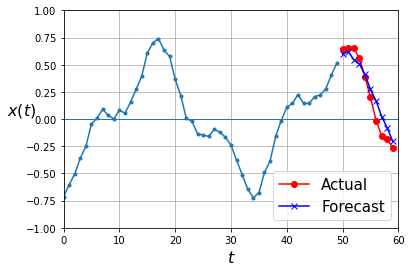

In [66]:
plot_multiple_forecast(X_new,Y_new,Y_pred)

## Deep RNN with Batch Norm

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10)),
])

model.compile(loss='mse',optimizer='adam',metrics=[last_time_step_mse])

history=model.fit(X_train,Y_train,epochs=20,
                 validation_data=(X_valid,Y_valid))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

217/219 [============================>.] - ETA: 0s - loss: 0.4789 - last_time_step_mse: 0.4789

<IPython.core.display.Javascript object>

219/219 [==============================] - 19s 35ms/step - loss: 0.4750 - last_time_step_mse: 0.4750 - val_loss: 0.0877 - val_last_time_step_mse: 0.0877
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0561 - last_time_step_mse: 0.0561 - val_loss: 0.0549 - val_last_time_step_mse: 0.0549
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0486 - last_time_step_mse: 0.0486 - val_loss: 0.0451 - val_last_time_step_mse: 0.0451
Epoch 4/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0443 - last_time_step_mse: 0.0443 - val_loss: 0.0418 - val_last_time_step_mse: 0.0418
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0414 - last_time_step_mse: 0.0414 - val_loss: 0.0391 - val_last_time_step_mse: 0.0391
Epoch 6/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0391 - last_time_step_mse: 0.0391 - val_loss: 0.0379 - val_last_time_step_mse: 0.0379
Epoch 7/20
219/219 [============

## Deep RNN with Layer Norm

In [73]:
from tensorflow.keras.layers import LayerNormalization

In [76]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self,units,activation='tanh',**kwargs):
        super().__init__(**kwargs)
        self.state_size= units
        self.output_size= units
        self.simple_rnn_cell= keras.layers.SimpleRNNCell(units,activation=None)
        self.layer_norm= LayerNormalization()
        self.activaion=keras.activations.get(activation)
    def get_initial_state(self,inputs=None,batch_size=None,dtype=None):
        if inputs is not None:
            batch_size=tf.shape(inputs)[0]
            dtype=inputs.dtype
        return [tf.zeros([batch_size,self.state_size],dtype=dtype)]
    def call(self,inputs,states):
        outputs,new_states=self.simple_rnn_cell(inputs,states)
        norm_outputs=self.activation(self.layer_norm(outputs))
        return norm_outputs,[norm_outputs]

<IPython.core.display.Javascript object>

In [81]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20),return_sequences=True,input_shape=[None,1]),
    keras.layers.RNN(LNSimpleRNNCell(20),return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse',optimizer='adam',metrics=[last_time_step_mse])
history=model.fit(X_train,Y_train,epochs=20,
                 validation_data=(X_valid,Y_valid))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

218/219 [============================>.] - ETA: 0s - loss: 0.2918 - last_time_step_mse: 0.2918

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

219/219 [==============================] - 22s 65ms/step - loss: 0.2906 - last_time_step_mse: 0.2906 - val_loss: 0.0754 - val_last_time_step_mse: 0.0754
Epoch 2/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0703 - last_time_step_mse: 0.0703 - val_loss: 0.0600 - val_last_time_step_mse: 0.0600
Epoch 3/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0589 - last_time_step_mse: 0.0589 - val_loss: 0.0530 - val_last_time_step_mse: 0.0530
Epoch 4/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0520 - last_time_step_mse: 0.0520 - val_loss: 0.0474 - val_last_time_step_mse: 0.0474
Epoch 5/20
219/219 [==============================] - 12s 55ms/step - loss: 0.0468 - last_time_step_mse: 0.0468 - val_loss: 0.0441 - val_last_time_step_mse: 0.0441
Epoch 6/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0428 - last_time_step_mse: 0.0428 - val_loss: 0.0385 - val_last_time_step_mse: 0.0385
Epoch 7/20
219/219 [=======

In [80]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]
    

<IPython.core.display.Javascript object>

## LSTMs

In [8]:
def last_time_step_mse(Y_true,Y_pred):
    return keras.metrics.mean_squared_error(Y_true,Y_pred)

In [14]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

218/219 [============================>.] - ETA: 0s - loss: 0.0981 - last_time_step_mse: 0.0981

<IPython.core.display.Javascript object>

219/219 [==============================] - 21s 62ms/step - loss: 0.0979 - last_time_step_mse: 0.0979 - val_loss: 0.0554 - val_last_time_step_mse: 0.0554
Epoch 2/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0515 - last_time_step_mse: 0.0515 - val_loss: 0.0427 - val_last_time_step_mse: 0.0427
Epoch 3/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0407 - last_time_step_mse: 0.0407 - val_loss: 0.0367 - val_last_time_step_mse: 0.0367
Epoch 4/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0356 - last_time_step_mse: 0.0356 - val_loss: 0.0334 - val_last_time_step_mse: 0.0334
Epoch 5/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0330 - last_time_step_mse: 0.0330 - val_loss: 0.0314 - val_last_time_step_mse: 0.0314
Epoch 6/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0313 - last_time_step_mse: 0.0313 - val_loss: 0.0298 - val_last_time_step_mse: 0.0298
Epoch 7/20
219/219 [=======

In [18]:
model.evaluate(X_valid,Y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0238 - last_time_step_mse: 0.0238


[0.023788679391145706, 0.02378867007791996]

## Char-RNN

In [4]:
shakespeare_url="https://homl.info/shakespeare"
filepath=tf.keras.utils.get_file("shakespeare.txt",shakespeare_url)
with open(filepath) as f:
    shakespeare_txt=f.read()

<IPython.core.display.Javascript object>

1122304/1115394 [==============================] - 2s 1us/step


In [8]:
tokenizer=tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts([shakespeare_txt])

<IPython.core.display.Javascript object>

In [10]:
tokenizer.texts_to_sequences(['First'])

[[20, 6, 9, 8, 3]]

In [11]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [14]:
max_id=len(tokenizer.word_index)
max_id

39

In [41]:
dataset_size=tokenizer.document_count
dataset_size

1

In [42]:
[encoded]=np.array(tokenizer.texts_to_sequences([shakespeare_txt]))-1

<IPython.core.display.Javascript object>

In [43]:
train_size=dataset_size*90//100

In [44]:
dataset=tf.data.Dataset.from_tensor_slices(encoded[:train_size])

<IPython.core.display.Javascript object>

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps=5
dataset=tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset=dataset.window(n_steps,shift=2,drop_remainder=True)
dataset=dataset.flat_map(lambda window:window.batch(n_steps))
dataset=dataset.shuffle(10).map(lambda window: (window[:-1],window[1:]))
dataset=dataset.batch(3).prefetch(1)

for index, (X_batch,Y_batch) in enumerate(dataset):
    print('_'*20,'Batch',index,'\nX_batch')
    print(X_batch.numpy())
    print('='*5,'\nY_batch')
    print(Y_batch.numpy())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


In [54]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

<IPython.core.display.Javascript object>

In [55]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [57]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

<IPython.core.display.Javascript object>

In [59]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count

In [60]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
n_steps=100
window_length=n_steps+1
dataset=dataset.window(window_length,shift=1,drop_remainder=True)
dataset=dataset.flat_map(lambda window:window.batch(window_length))

In [62]:
np.random.seed(42)
tf.random.set_seed(42)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
batch_size=32
dataset=dataset.shuffle(1000).batch(batch_size)
dataset=dataset.map(lambda windows: (windows[:,:-1],windows[:,1:]))

In [64]:
dataset=dataset.map(
                lambda X_batch, Y_batch :(tf.one_hot(X_batch,depth=max_id),Y_batch))

<IPython.core.display.Javascript object>

In [65]:
dataset=dataset.prefetch(1)

In [66]:
for X_batch,Y_batch in dataset.take(1):
    print(X_batch.shape,Y_batch.shape)

(32, 100, 39) (32, 100)


## Building and Training the Char-RNN model

In [ ]:
model=keras.models.Sequential([
    keras.layers.GRU(128,return_sequences=True,input_shape=[None,max_id],
                    dropout=0.2,recurrent_dropout=0.2),
    keras.layers.GRU(128,return_sequences=True,
                    dropout=0.2,recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,activation='softmax'))
    
])

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam')
history=model.fit(dataset,epochs=10)

In [ ]:
## Model will take alot of computation power in order to get run successfully.